In [1]:
from time import time
from configparser import ConfigParser
import pathlib as pl
from math import factorial

import joblib as jl
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

from src.root_path import config_path

In [2]:
config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 1000,
        'zscore': True,
        'stim_type': 'permutations'}

t_statistic=pl.Path(config['paths']['analysis_cache']) / f'220303_ctx_mod_metric_DF_tstat_cluster_mass'
t_statistic=pl.Path(config['paths']['analysis_cache']) / f'220310_ctx_mod_metric_DF_tstat_cluster_mass_BS'

### same example cell as in figure 1 ###
prb_idx = 3 - 1# selected probe. the -1 is to acount for 0 not being used
ctx_pair = [0,1] # pair of contexts to compare and exemplify d'
cellid = 'ARM021b-36-8'

longDF = jl.load(t_statistic)

### single cell coverage histogram

In [3]:
ctx_prb_count = longDF.groupby(['source', 'analysis', 'region', 'cluster_threshold',
                                'mult_comp_corr', 'id', 'metric' ]).agg(
    space_cover_pct=("value", lambda x: sum(x>0)/len(x)*100))
ctx_prb_count.head()


space_cover_pct
source analysis region cluster_threshold mult_comp_corr id           metric                      
real   SC       A1     0.01              bf_cp          AMT020a-02-1 integral                 7.5
                                                                     last_bin                 7.5
                                                                     mass_center              7.5
                                                        AMT020a-04-1 integral                 5.0
                                                                     last_bin                 5.0

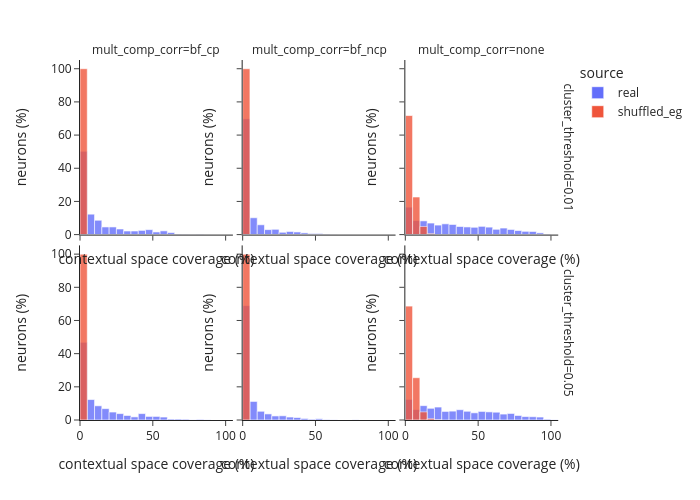

In [4]:
ctx_prb_count = longDF.groupby(['source', 'analysis', 'region', 'cluster_threshold',
                                'mult_comp_corr', 'id', 'metric' ]).agg(
    space_cover_pct=("value", lambda x: sum(x>0)/len(x)*100)).reset_index()
hist_data = ctx_prb_count.query("analysis == 'SC' and metric == 'integral'")

fig = px.histogram(data_frame=hist_data, x="space_cover_pct", nbins=50,
                   color='source', facet_row='cluster_threshold', facet_col='mult_comp_corr',
                   histnorm='percent',
                   opacity=0.8, barmode='overlay')
fig.update_xaxes(title=dict(text='contextual space coverage (%)'))
fig.update_yaxes(title=dict(text='neurons (%)'))
fig.update_layout(template='simple_white', showlegend=True)

# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

# Subsampling plots

In [73]:
subsampling_path = pl.Path(config['paths']['analysis_cache']) / '220310_pval_subsamp_DF'
subDF = jl.load(subsampling_path)
print(subDF.columns)
def surface_plot(DF, metric):
    fig = make_subplots(rows=1, cols=3,
                        shared_xaxes=True, shared_yaxes=True,
                        specs=[[{'type': 'xy'}, {'type': 'xy'}, {'type': 'scene'}]])

    ##### real values #####
    real= DF.groupby(['source', 'n_ctx', 'n_prb']).agg('mean').loc['real'].reset_index().pivot(
        index='n_prb', columns='n_ctx', values=metric)

    # heatmap
    hm = go.Heatmap(x=real.index.values, y=real.columns.values, z=real.values,
                    coloraxis='coloraxis')
    _ = fig.add_trace(hm, row=1, col=1)
    _ = fig.update_xaxes(title_text='# different probess',
                         anchor='y', constrain='domain', scaleanchor='y',
                         row=1, col=1)
    _ = fig.update_yaxes(title_text='# different contexts',
                         anchor='x', autorange=True, constrain='domain',
                         row=1, col=1)

    # surface
    sf = go.Surface(z=real.values, x=real.index, y=real.columns,
                    coloraxis='coloraxis', opacity=0.9)
    fig.add_trace(sf, row=1, col=3)

    ##### shuffled example #####
    shuffled = DF.groupby(['source', 'n_ctx', 'n_prb']).agg('mean').loc['shuffled_eg'].reset_index().pivot(
        index='n_prb', columns='n_ctx', values=metric)

    # heatmap
    hm = go.Heatmap(x=shuffled.index.values, y=shuffled.columns.values, z=shuffled.values,
                    coloraxis='coloraxis')
    _ = fig.add_trace(hm, row=1, col=2)
    _ = fig.update_xaxes(title_text='# different probess',
                         anchor='y2', constrain='domain', scaleanchor='y2',
                         row=1, col=2)
    _ = fig.update_yaxes(anchor='x2', autorange=True, constrain='domain',
                         row=1, col=2)

    # surface
    sf = go.Surface(z=shuffled.values, x=shuffled.index, y=shuffled.columns,
                    coloraxis='coloraxis', opacity=0.9)
    fig.add_trace(sf, row=1, col=3)

    ##### general

    fig.update_layout(scene=dict(xaxis=dict(title='# probes',
                                            ticktext=real.index.values,
                                            tickvals=real.index.values),
                                 yaxis=dict(title="# contexts",
                                            ticktext=real.columns.values,
                                            tickvals=real.columns.values),
                                 zaxis=dict(title='%')
                                 ),
                      autosize=True,
                      scene_camera_eye=dict(x=-1.5, y=-1.5, z=0.5),
                      coloraxis=dict(cmin=0, cmax=100,
                                     colorscale='inferno',
                                     colorbar=dict(
                                         title=dict(
                                             text=f'{metric} (%)',
                                             side='right'
                                         ))),
                      margin=dict(l=50,r=50,b=50,t=50,pad=4))
    return fig

Index(['source', 'region', 'site', 'recruited_neu_pct', 'coverage_percent',
       'n_prb', 'n_ctx'],
      dtype='object')


## percentage of recruited neurons per site

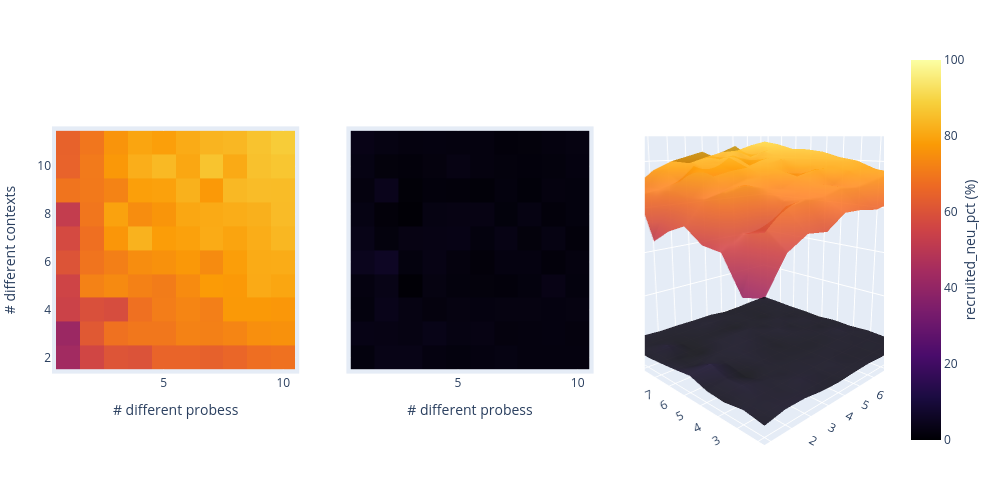

In [81]:
fig = surface_plot(subDF, 'recruited_neu_pct')
# fig.show()
img_bytes = fig.to_image(format="png", width=1000)
Image(img_bytes)

## similar plot than before, just using a randomly shuffled dprime as a floor level

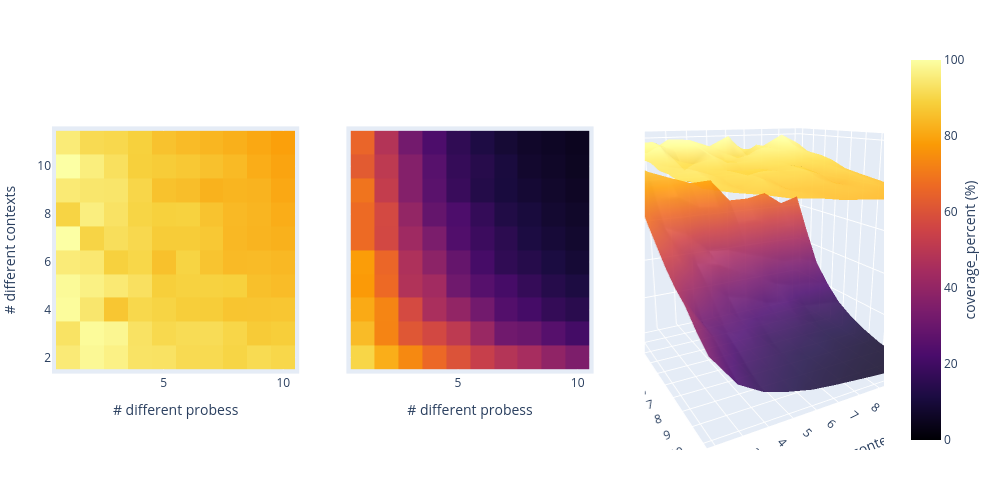

In [82]:
fig = surface_plot(subDF, 'coverage_percent')
fig.update_layout(scene_camera_eye=dict(x=1.8, y=-1, z=0.6),)

# fig.show()
img_bytes = fig.to_image(format="png", width=1000)
Image(img_bytes)

### number of shuffles required

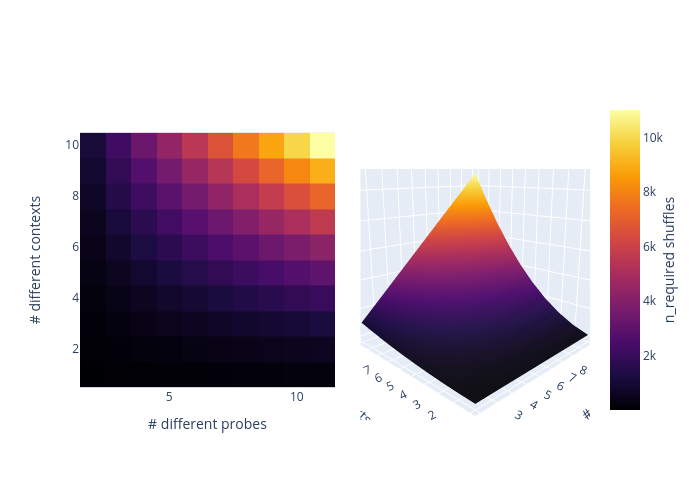

In [10]:
grid = np.empty((10,10))

for ictx, iprb in np.ndindex(grid.shape):
    nctx = ictx+2
    nprb = iprb + 1
    n_ctx_pairs = factorial(nctx) / (2 * factorial(nctx - 2))
    n_comparison = n_ctx_pairs * nprb
    alpha = 0.05 / n_comparison
    grid[ictx, iprb] = 1/alpha

x_lab = np.arange(start=2, stop=12)
y_lab = np.arange(start=1, stop=11)
x = x_lab
y = y_lab

fig = make_subplots(rows=1, cols=2,
                        specs=[[{'type': 'xy'}, {'type': 'scene'}]])
hm = go.Heatmap(x=x, y=y, z=grid,
                coloraxis='coloraxis')

_ = fig.add_trace(hm, row=1, col=1)
_ = fig.update_xaxes(title_text='# different probes',
                     anchor='y', constrain='domain', domain=[0, 0.5], scaleanchor='y')
_ = fig.update_yaxes(title_text='# different contexts',
                     anchor='x', autorange=True, constrain='domain', domain=[0, 1])

sf = go.Surface(x=x, y=y, z=grid,
                coloraxis='coloraxis')
_ = fig.add_trace(sf, row=1, col=2)
_ = fig.update_layout(scene=dict(xaxis=dict(title='# probes',
                                        ticktext=x_lab,
                                        tickvals=x_lab),
                             yaxis=dict(title="# contexts",
                                        ticktext=y_lab,
                                        tickvals=y_lab),
                             zaxis=dict(title='%')
                             ),
                  autosize=True,
                  scene_camera_eye=dict(x=-1.5, y=-1.5, z=0.5),
                  coloraxis=dict(colorscale='inferno',
                                 colorbar=dict(
                                     title=dict(
                                         text=f'n_required shuffles',
                                         side='right'
                                     ))))

img_bytes = fig.to_image(format="png")
Image(img_bytes)
# fig.show()